In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
from configs import task_dataframe

In [3]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
df = pd.read_pickle(f'{root_dir}/results/results.pkl')

# Configuration

In [5]:
def get_acc(model, mode, shot, task_id, metric, misleading):
    run_df = df[
        (df['model'] == model) &
        (df['file_type'] == mode) &
        (df['shot'] == shot) &
        (df['task_id'] == task_id) &
        (df['misleading'] == misleading)
    ]
    
    if len(run_df):
        # check whether it is nan or not
        if np.isnan(float(run_df[metric].iloc[0])):
            return 0
        else:
            return float(run_df[metric].item())/1000            
    else:
        return 0

In [6]:
get_acc(
    model = 'gpt4v',
    mode = 'text',
    shot = 2,
    task_id = 1,
    metric = 'overall',
    misleading = 0,
)

0.844

In [7]:
model_dict = {
    'image': {
        'emu': 'Emu',
        # 'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
    },
    'text': {
        'emu': 'Emu',
        # 'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
        'llava': 'LLaVA',
        'qwen': 'Qwen-VL',
        'gpt4v': 'GPT-4V',
    }
}

colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

# Overall Perforamnce Report

In [8]:
def get_shot_bars(
    num_shot,
    task_inference,
    model_mode,
    metric,
    misleading,
):
    task_df = pd.DataFrame(task_dataframe).T
    results = []
    if task_inference == 'object':
        tasks = task_df[(task_df.theta_space == 'object') | (task_df.theta_space == 'animal')]
    else:
        tasks = task_df[(task_df.theta_space != 'object') & (task_df.theta_space != 'animal')]
    for task_id in tasks.index:
        for model_label in model_dict[model_mode]:
            acc = get_acc(
                model = model_label,
                mode = model_mode,
                shot = num_shot,
                task_id = task_id,
                metric = metric,
                misleading = misleading,
            )
            results.append({
                'acc': acc,
                'model': model_label,
                'task_id': task_id,
                'task': task_dataframe[task_id]['task_name']
            })
            
    results_df = pd.DataFrame(results)
    return results_df


In [9]:
get_shot_bars(
    num_shot = 2,
    task_inference ='object',
    model_mode = 'text',
    metric = 'overall',
    misleading = 0,
)

,acc,model,task_id,task
0,0.146,emu,1,Color-I
1,0.077,gill,1,Color-I
2,0.129,seed,1,Color-I
3,0.049,llava,1,Color-I
4,0.475,qwen,1,Color-I
5,0.844,gpt4v,1,Color-I
6,0.404,emu,3,Background-I
7,0.035,gill,3,Background-I
8,0.019,seed,3,Background-I
9,0.027,llava,3,Background-I


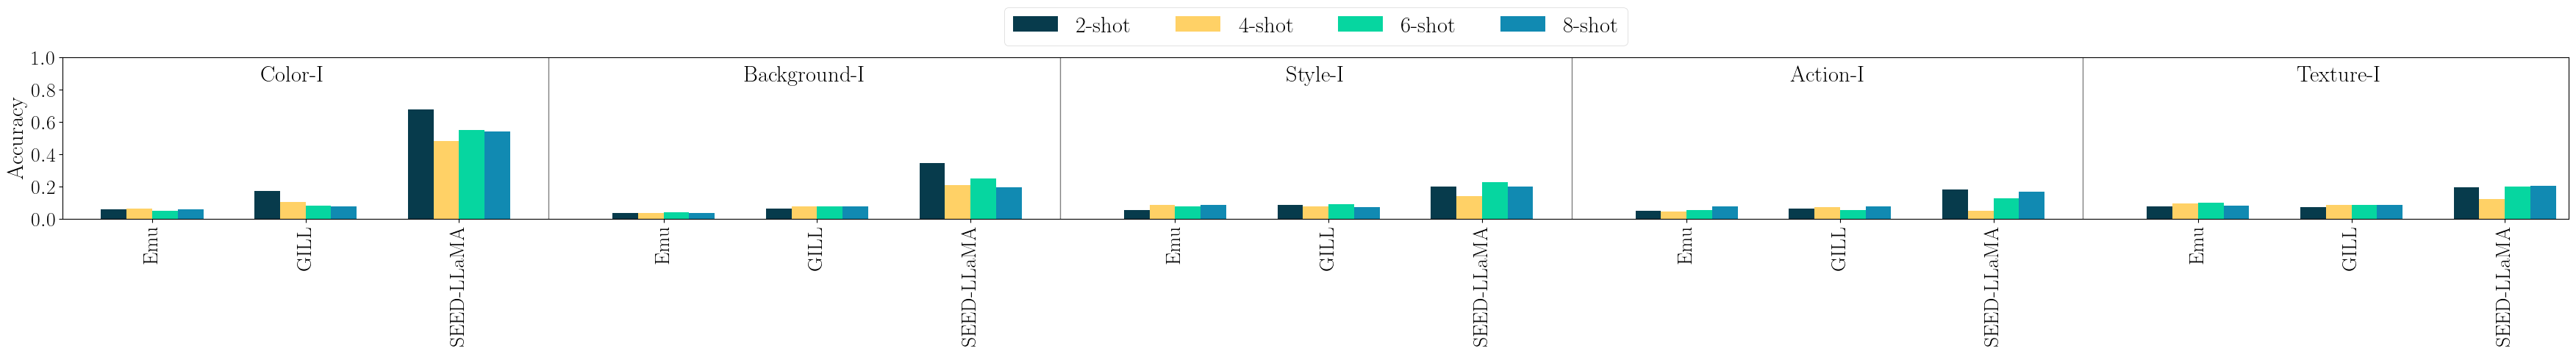

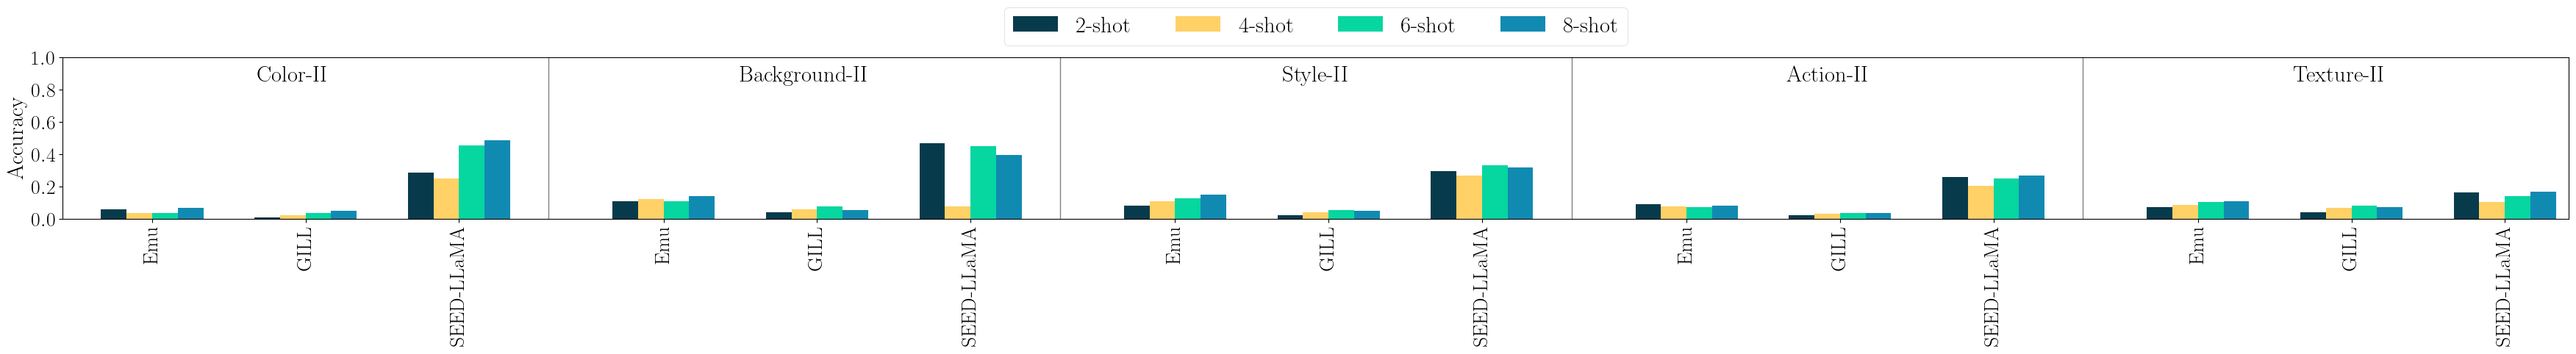

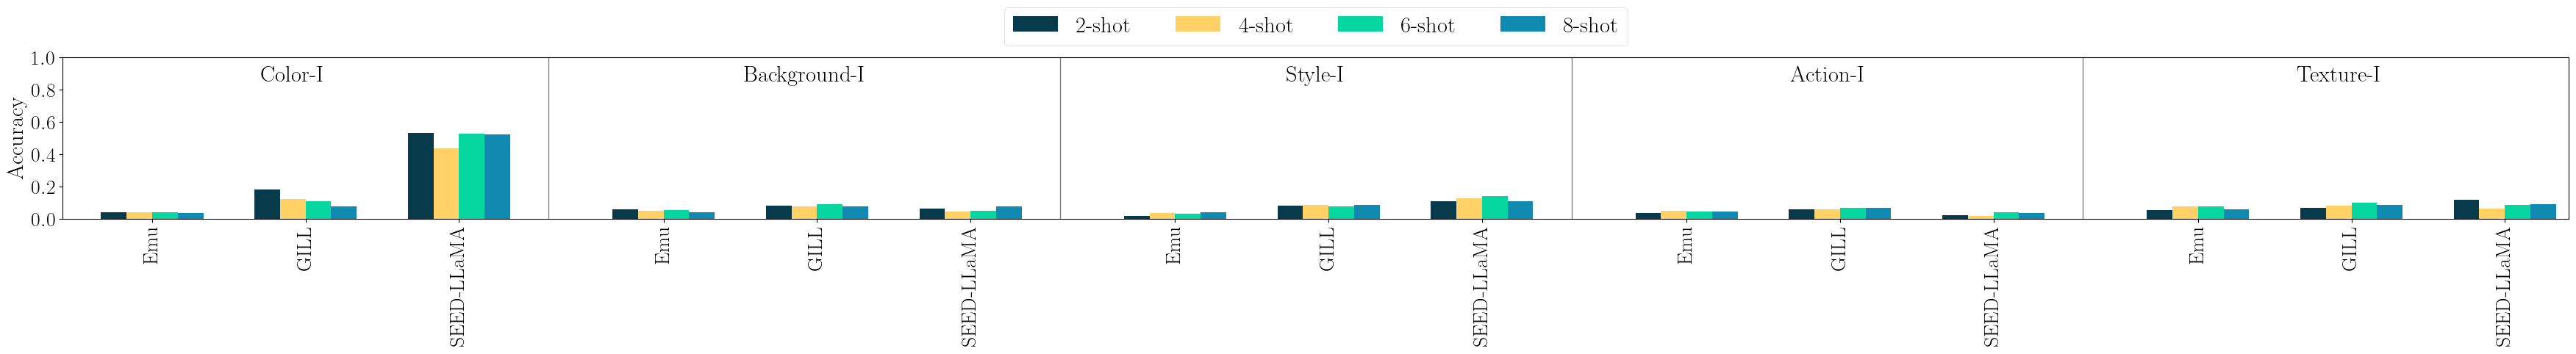

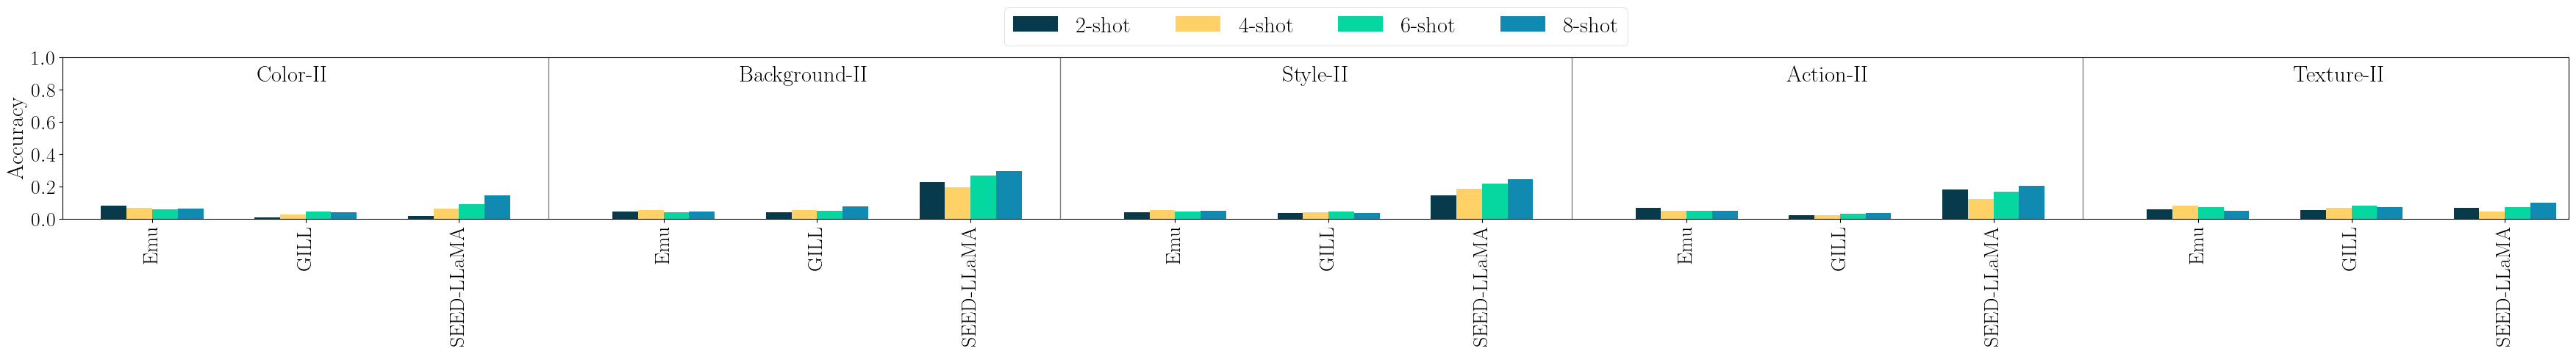

In [10]:
model_mode = 'image'
for misleading in [0,1]:
    for task_inference in ['object', 'detail']:
        bar_width = 2.5
        # ask_inference = task_inference
        # model_mode = model_mode
        width, height = 35, 5
        # misleading = misleading
        metric = 'overall'
        wspace = 5
        barspace = 15

        r1_data = get_shot_bars(
            num_shot = 2,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


        r2_data = get_shot_bars(
            num_shot = 4,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

        r3_data = get_shot_bars(
            num_shot = 6,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

        r4_data = get_shot_bars(
            num_shot = 8,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticks, xticklabels = [], []
        for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
            ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
            ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
            ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
            ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
            xticks.append((v2['position'] + v3['position'])/2)
            xticklabels.append(model_dict[model_mode][v3['model']])
            
            if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
                ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
                
            if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
                if not i // len(model_dict[model_mode]) == 4:
                    ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
            
            # add legend
            if i == 0:
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
                
        ax.set_xticks(xticks)
        ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
        # break the line of the xticklabels
        ax.set_xticklabels(xticklabels, rotation = 90)
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        # set ylabel 
        ax.set_ylabel('Accuracy', fontsize=22)
        save_path = f'{root_dir}/figures/{task_inference}_inference_m_{misleading}_{model_mode}.pdf'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path)
        plt.show()

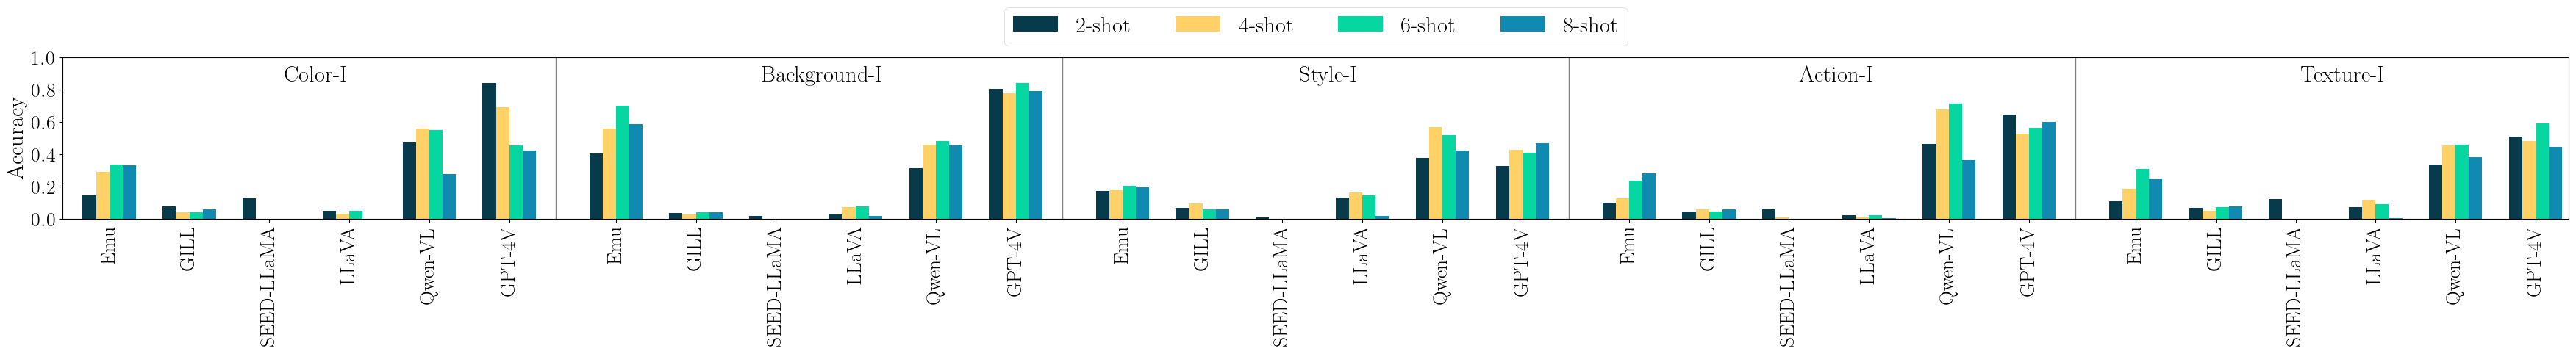

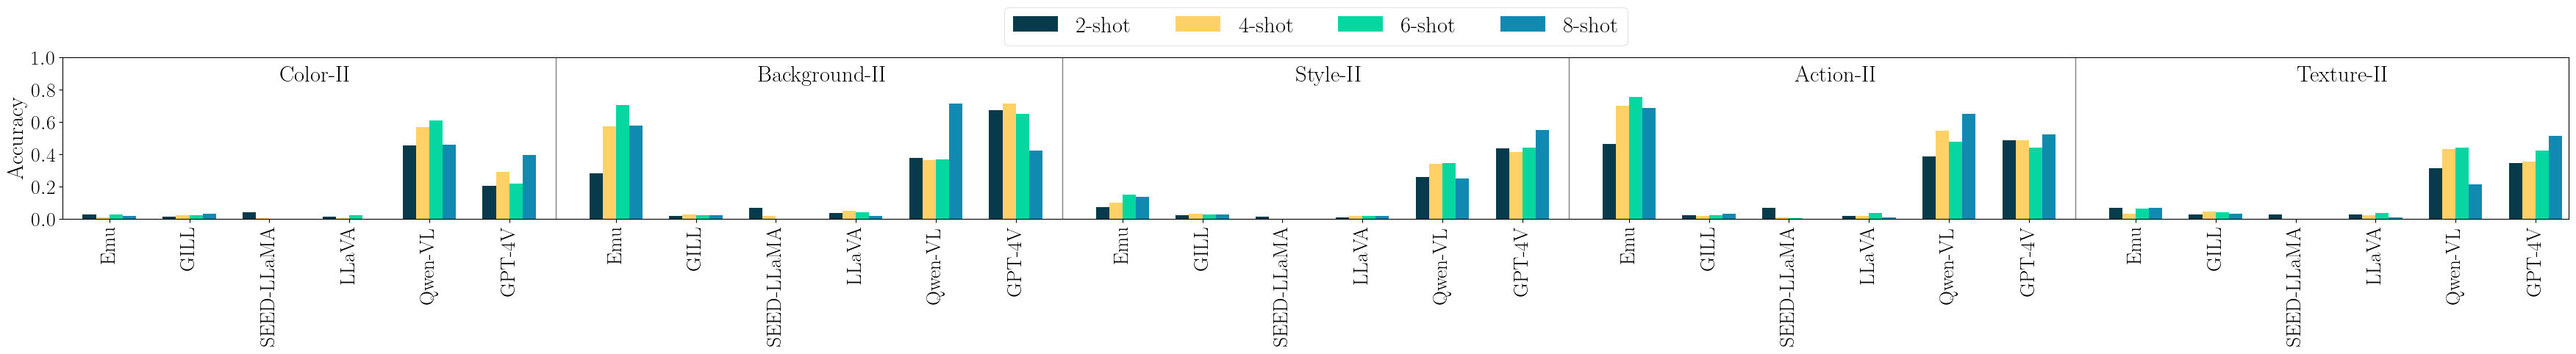

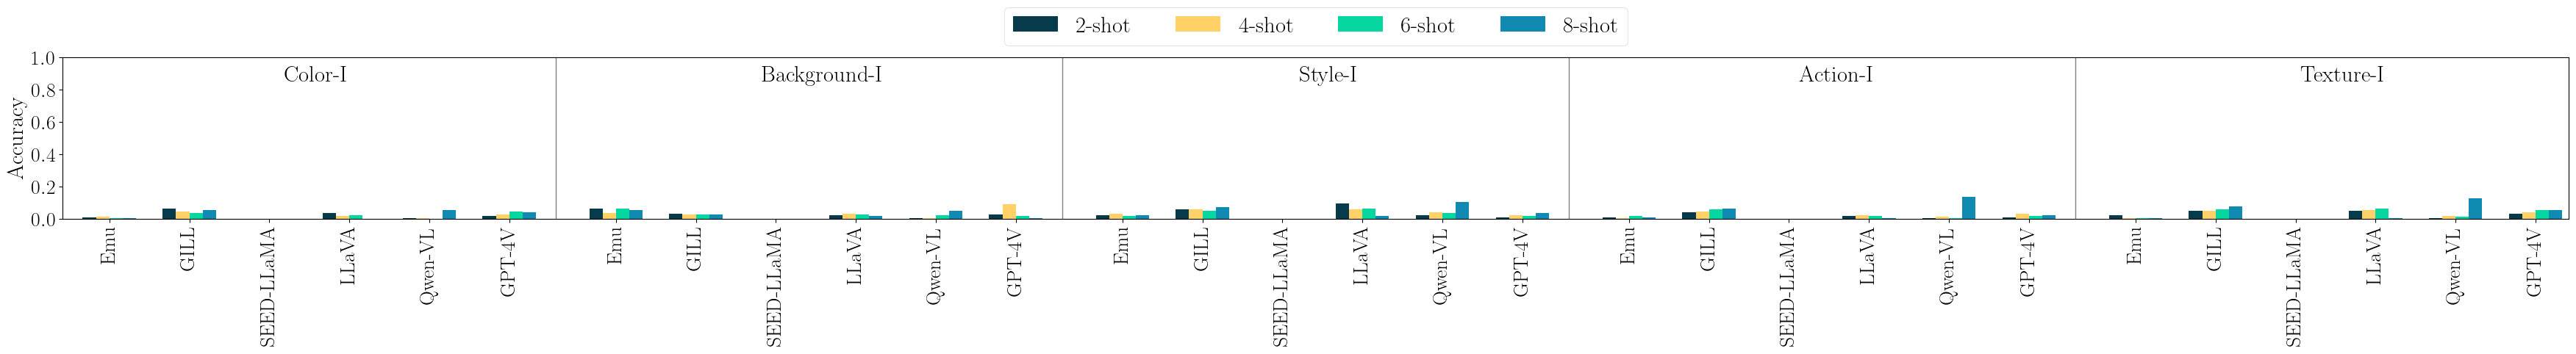

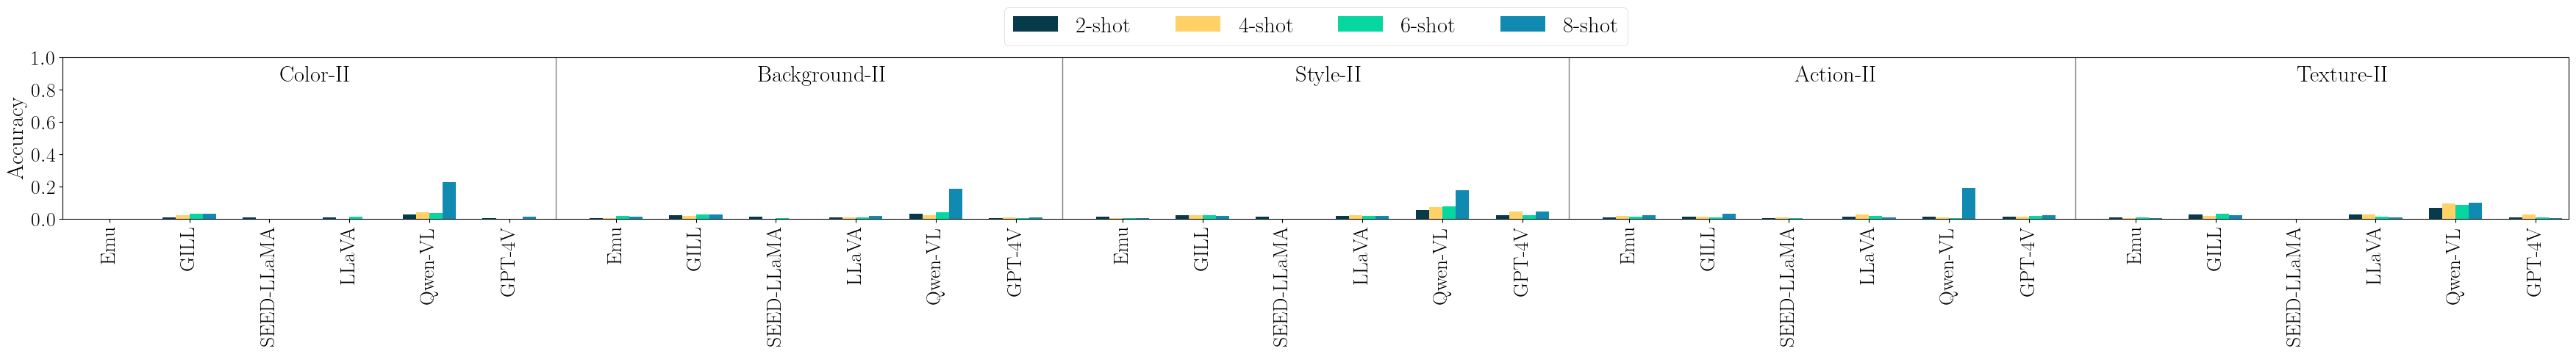

In [11]:
model_mode = 'text'
for misleading in [0,1]:
    for task_inference in ['object', 'detail']:
        bar_width = 2.5
        # ask_inference = task_inference
        # model_mode = model_mode
        width, height = 35, 5
        # misleading = misleading
        metric = 'overall'
        wspace = 5
        barspace = 15

        r1_data = get_shot_bars(
            num_shot = 2,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


        r2_data = get_shot_bars(
            num_shot = 4,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

        r3_data = get_shot_bars(
            num_shot = 6,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

        r4_data = get_shot_bars(
            num_shot = 8,
            task_inference = task_inference,
            model_mode = model_mode,
            metric = metric,
            misleading = misleading,
        )
        r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticks, xticklabels = [], []
        for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
            ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
            ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
            ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
            ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
            xticks.append((v2['position'] + v3['position'])/2)
            xticklabels.append(model_dict[model_mode][v3['model']])
            
            if i % len(model_dict[model_mode]) == (len(model_dict[model_mode]))//2:
                ax.text(v2['position'] - wspace, 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
                
            if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
                if not i // len(model_dict[model_mode]) == 4:
                    ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
            
            # add legend
            if i == 0:
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
                
        ax.set_xticks(xticks)
        ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
        # break the line of the xticklabels
        ax.set_xticklabels(xticklabels, rotation = 90)
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        # set ylabel 
        ax.set_ylabel('Accuracy', fontsize=22)
        save_path = f'{root_dir}/figures/{task_inference}_inference_m_{misleading}_{model_mode}.pdf'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path)
        plt.show()

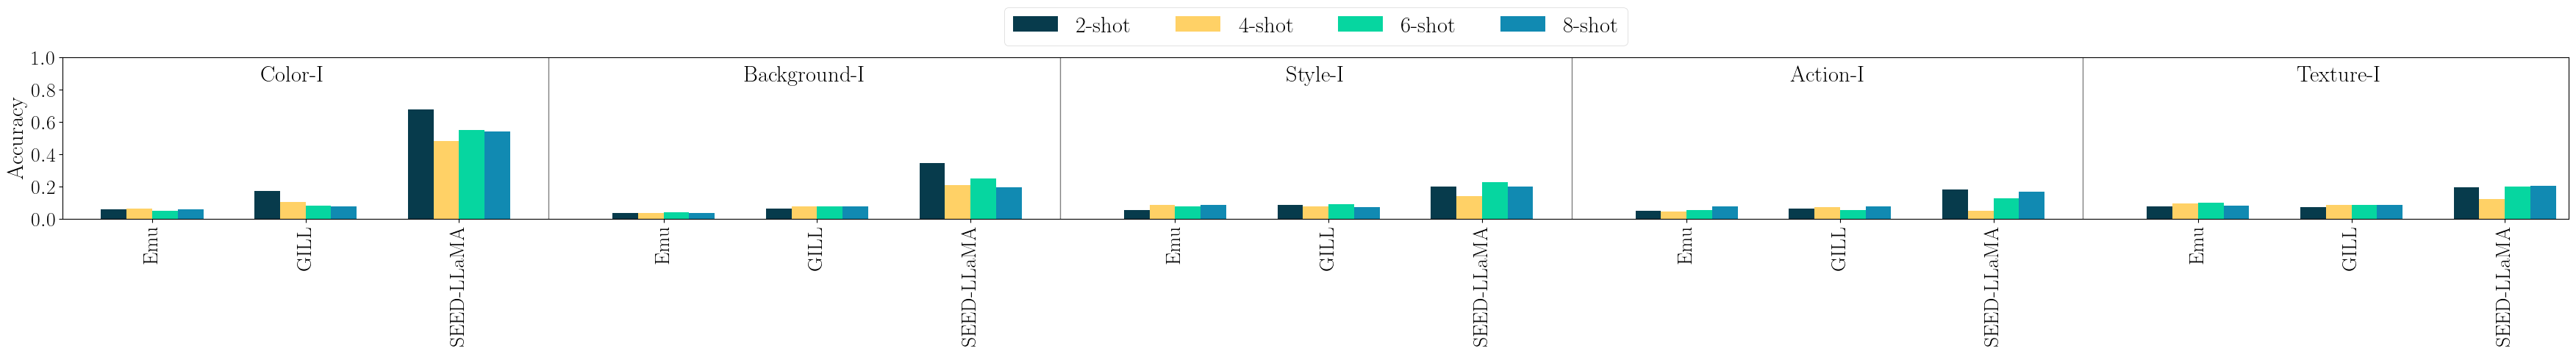

In [12]:
bar_width = 2.5
task_inference = 'object'
model_mode = 'image'
width, height = 35, 5
misleading = 0
metric = 'overall'
wspace = 5
barspace = 15

r1_data = get_shot_bars(
    num_shot = 2,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


r2_data = get_shot_bars(
    num_shot = 4,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    num_shot = 6,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

r4_data = get_shot_bars(
    num_shot = 8,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
    ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
    xticks.append((v2['position'] + v3['position'])/2)
    xticklabels.append(model_dict[model_mode][v3['model']])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
        
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
        if not i // len(model_dict[model_mode]) == 4:
            ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
        
ax.set_xticks(xticks)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_yticks(np.arange(0, 1.2, 0.2))
# set ylabel 
ax.set_ylabel('Accuracy', fontsize=22)
save_path = f'{root_dir}/figures/{task_inference}_inference_m_{misleading}_{model_mode}.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path)
plt.show()

# Analyze the effect of number of demonstrations

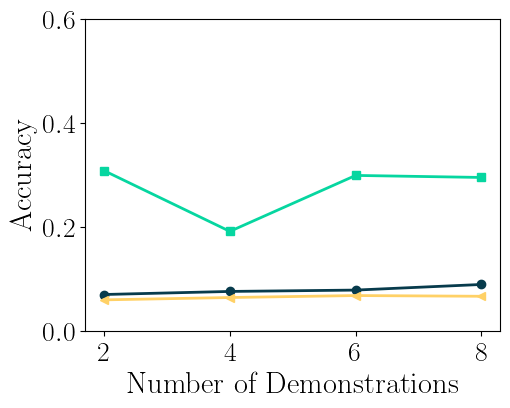

In [13]:
model_mode = 'image'
metric = 'overall'
misleading = 0
width, height = 5,4
num_shots = [2,4,6,8]

results = {}
for model in model_dict[model_mode]:
    results[model] = defaultdict(list)
    for shot in num_shots:
        for task_id in task_dataframe:
            results[model][shot].append(get_acc(
                model = model,
                mode = model_mode,
                shot = shot,
                task_id = task_id,
                metric = metric,
                misleading = misleading,
            ))
        
        results[model][shot] = np.mean(results[model][shot])
results = pd.DataFrame(results)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.16, bottom=.18, right=0.99, top=.96, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

for i, model in enumerate(results):
    results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
ax.set_xticks(num_shots)
ax.set_xticklabels(num_shots)
ax.set_ylim(0,.6)
ax.set_xlabel('Number of Demonstrations', fontsize=22)
ax.set_ylabel('Accuracy', fontsize=22)
# ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=len(model_dict[model_mode]), fontsize=15)

fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{misleading}.pdf')
plt.show()

In [14]:
ylim = {
    'overall': .6,
    'detail': 1,
    'obj': 1,
    'textual':1,
    'visual':1,
}

ylabel = {
    'overall': 'Accuracy',
    'detail': 'Attribute-Generation Accuracy',
    'obj': 'Object-Generation Accuracy',
    'textual': 'Textual-Generation Accuracy',
    'visual': 'Visual-Generation Accuracy',
}

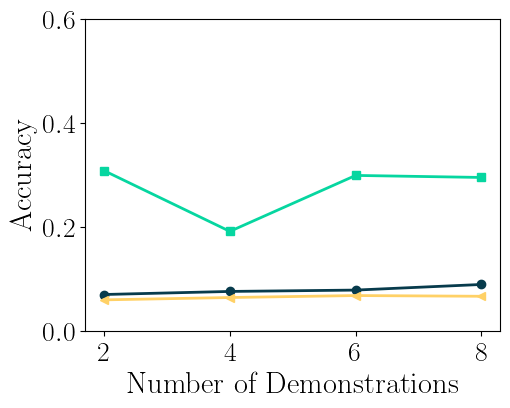

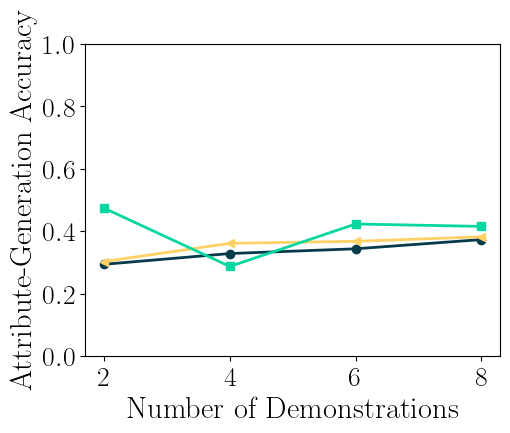

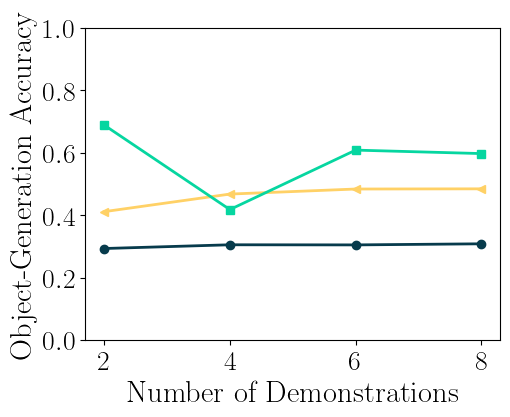

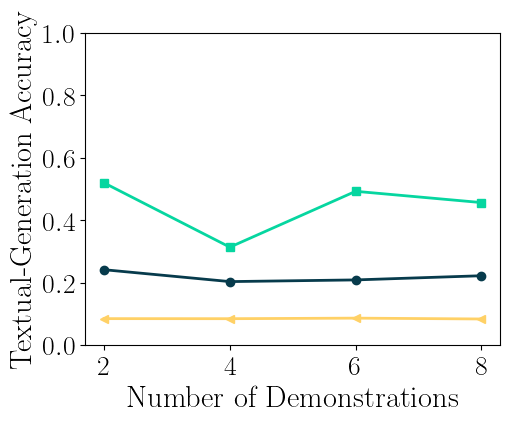

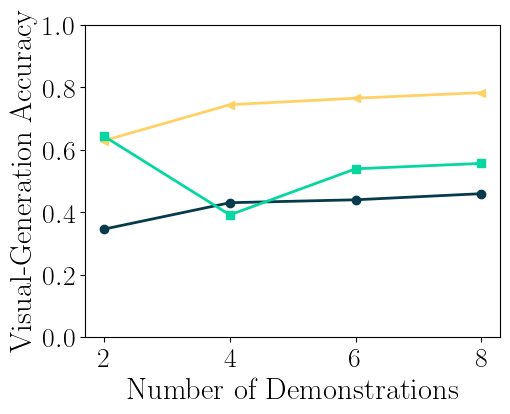

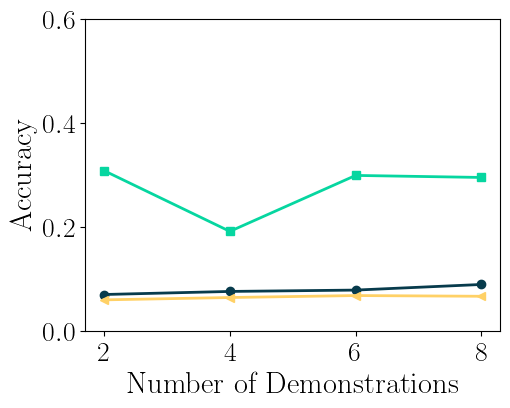

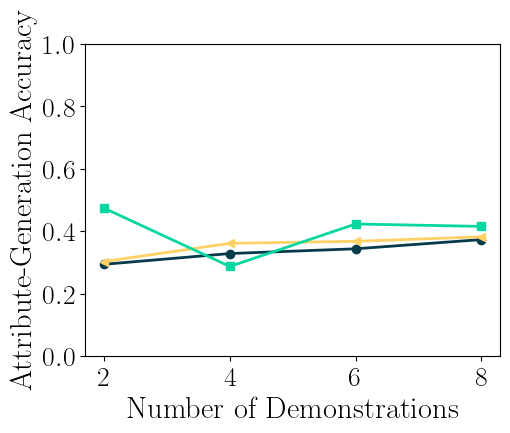

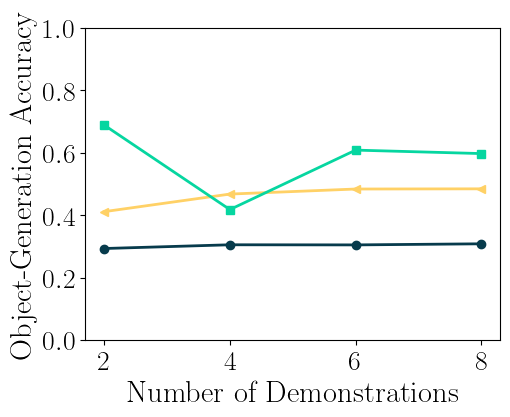

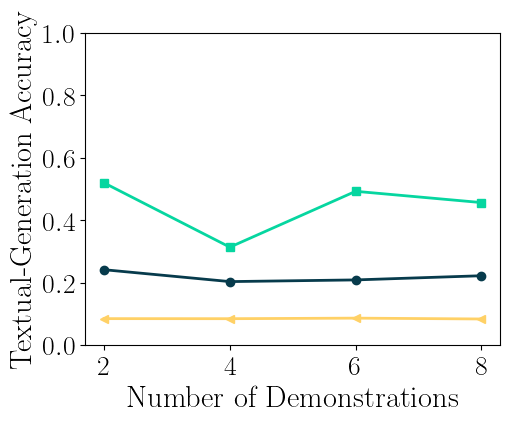

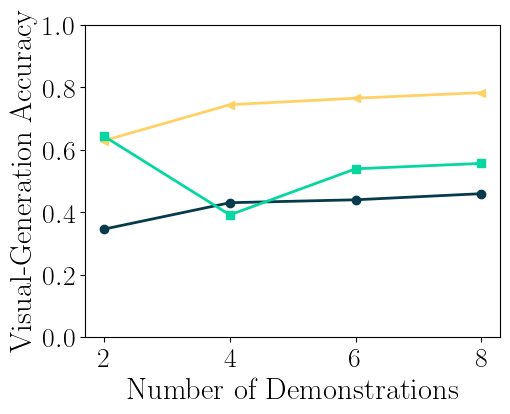

In [15]:
model_mode = 'image'
misleading = 0
width, height = 5,4
num_shots = [2,4,6,8]

for misleading in [0,1]:
    for metric in ['overall', 'detail', 'obj', 'textual', 'visual']:
        misleading = 0
        width, height = 5,4
        num_shots = [2,4,6,8]

        results = {}
        for model in model_dict[model_mode]:
            results[model] = defaultdict(list)
            for shot in num_shots:
                for task_id in task_dataframe:
                    results[model][shot].append(get_acc(
                        model = model,
                        mode = model_mode,
                        shot = shot,
                        task_id = task_id,
                        metric = metric,
                        misleading = misleading,
                    ))
                
                results[model][shot] = np.mean(results[model][shot])
        results = pd.DataFrame(results)

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.16, bottom=.18, right=0.99, top=.96, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        for i, model in enumerate(results):
            results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
        ax.set_xticks(num_shots)
        ax.set_xticklabels(num_shots)
        ax.set_ylim(0,ylim[metric])
        ax.set_xlabel('Number of Demonstrations', fontsize=22)
        ax.set_ylabel(ylabel[metric], fontsize=22)
        # ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=len(model_dict[model_mode]), fontsize=15)

        fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{misleading}_{metric}.pdf')
        plt.show()

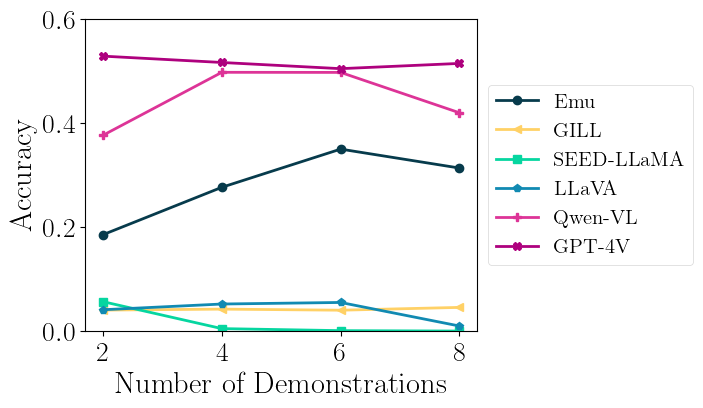

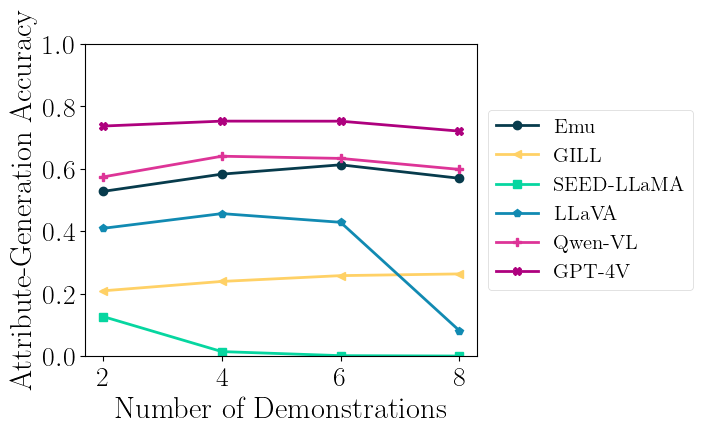

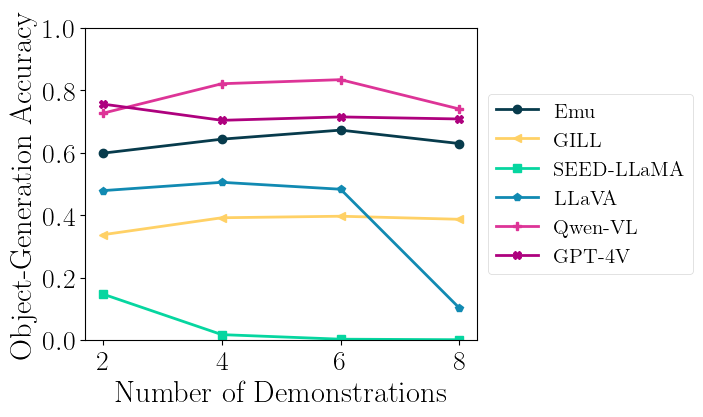

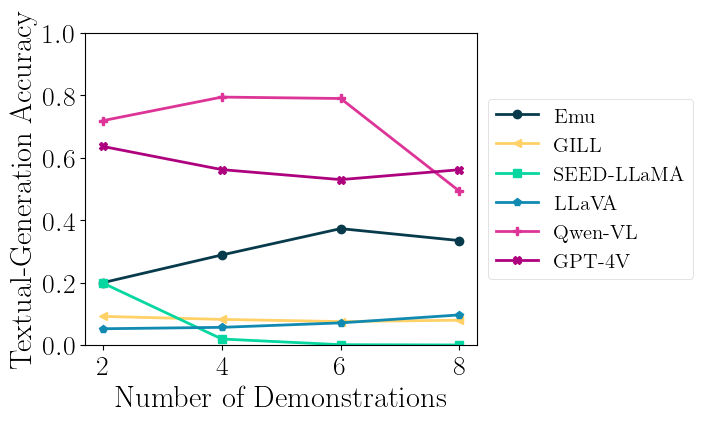

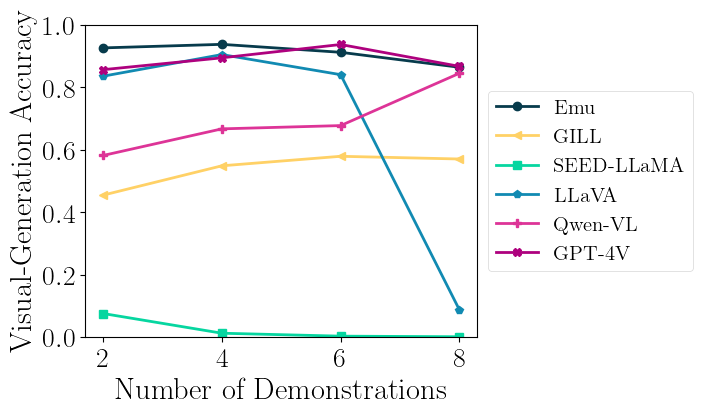

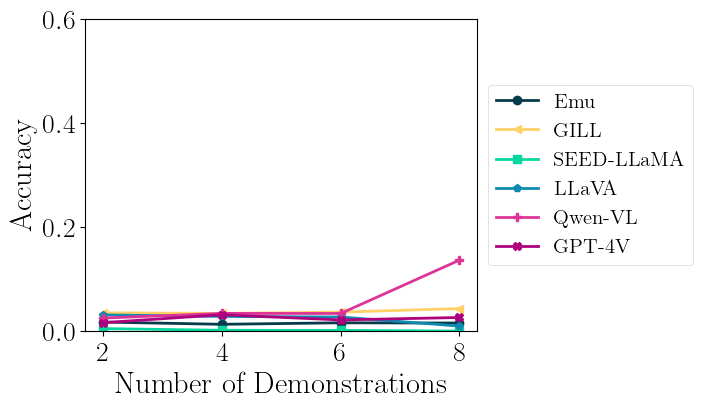

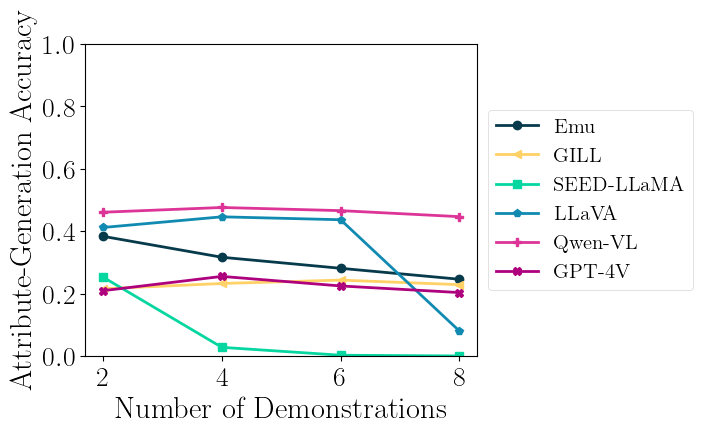

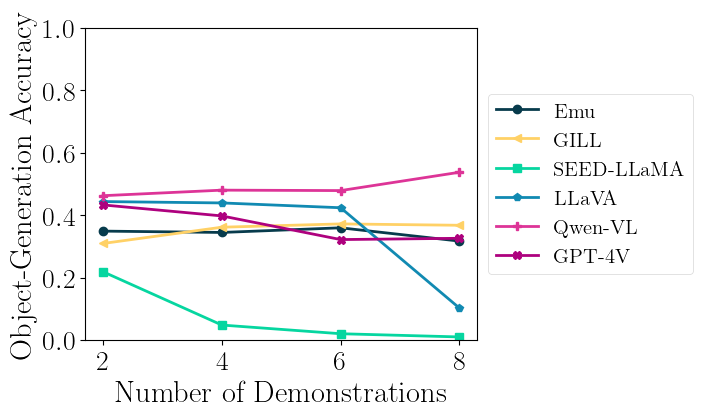

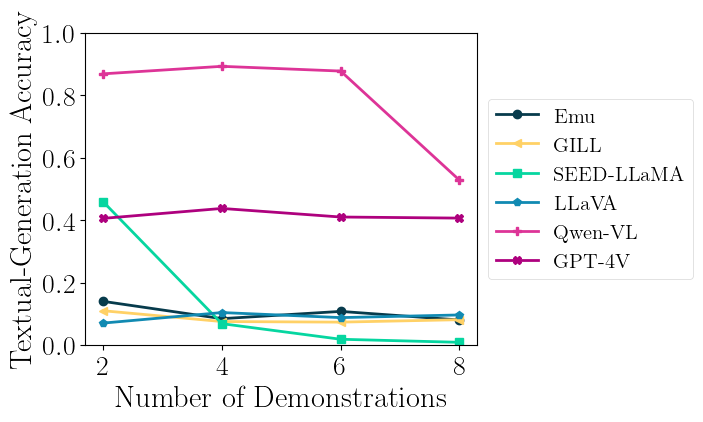

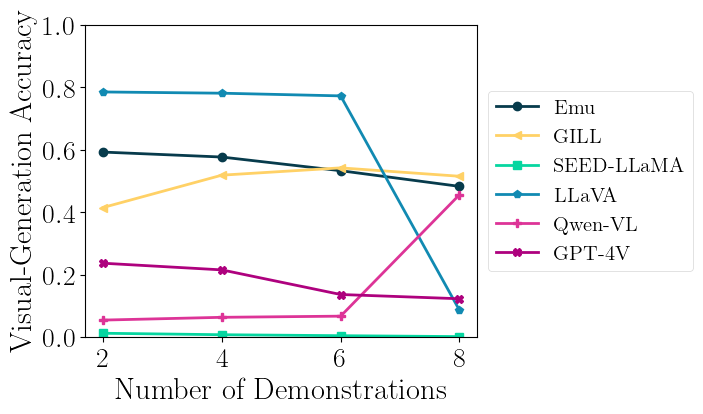

In [16]:
model_mode = 'text'
misleading = 0
width, height = 7,4
num_shots = [2,4,6,8]

for misleading in [0,1]:
    for metric in ['overall', 'detail', 'obj', 'textual', 'visual']:
        results = {}
        for model in model_dict[model_mode]:
            results[model] = defaultdict(list)
            for shot in num_shots:
                for task_id in task_dataframe:
                    results[model][shot].append(get_acc(
                        model = model,
                        mode = model_mode,
                        shot = shot,
                        task_id = task_id,
                        metric = metric,
                        misleading = misleading,
                    ))
                
                results[model][shot] = np.mean(results[model][shot])
        results = pd.DataFrame(results)

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.12, bottom=.18, right=0.68, top=.96, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        for i, model in enumerate(results):
            results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
        ax.set_xticks(num_shots)
        ax.set_xticklabels(num_shots)
        ax.set_xlabel('Number of Demonstrations', fontsize=22)
        ax.set_ylabel(ylabel[metric], fontsize=22)
        ax.set_ylim(0,ylim[metric])
        # reduce the space between the legend and the figure
        ax.legend(loc='center left', bbox_to_anchor=(1, .5), ncol=1, fontsize=15)

        fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{misleading}_{metric}.pdf')
        plt.show()

# Object inference v.s. detail inference

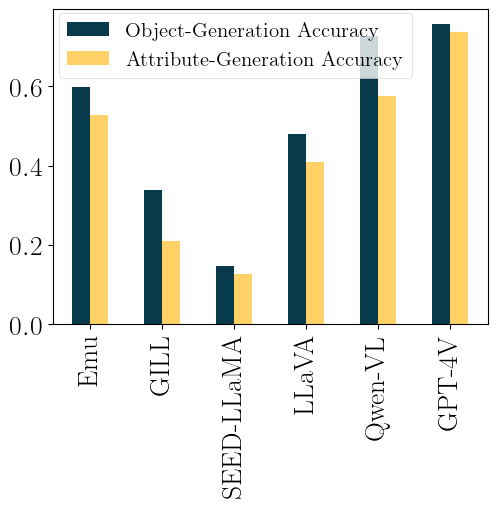

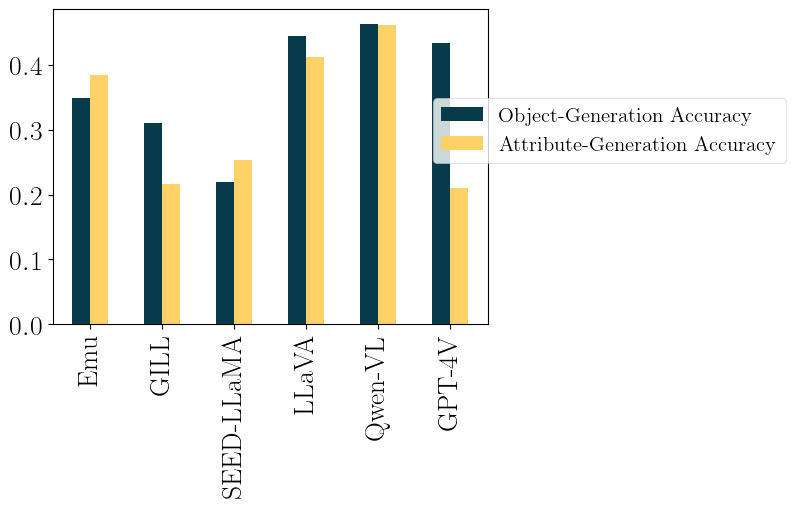

In [21]:
model_mode = 'text'
misleading = 0
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10

for model_mode in ['text']:
    for misleading in [0,1]:
        results = {}
        for metric in ['obj', 'detail']:
            results[metric] = {}
            for model in model_dict[model_mode]:
                results[metric][model] = {}
                for shot in num_shots:
                    results[metric][model][shot] = []
                    for task_id in task_dataframe:
                        results[metric][model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            misleading = misleading,
                        ))
                    results[metric][model][shot] = np.mean(results[metric][model][shot])

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.98, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticklabels = []
        for i, model in enumerate(model_dict[model_mode]):
            ax.bar(barspace*i, results['obj'][model][num_shot], width = bar_width, color = colors[0], label = 'Object-Generation Accuracy')
            ax.bar(barspace*i + bar_width, results['detail'][model][num_shot], width = bar_width, color = colors[1], label = 'Attribute-Generation Accuracy')
            xticklabels.append(model_dict[model_mode][model])
            
            if i == 0: ax.legend(bbox_to_anchor=(.85, .75), ncol=1, fontsize=15)
            
        ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
        ax.set_xticklabels(xticklabels, rotation = 90)
        fig.savefig(f'{root_dir}/figures/impact_obj_detail_shot_{num_shot}_{model_mode}_{misleading}.pdf')
        plt.show()

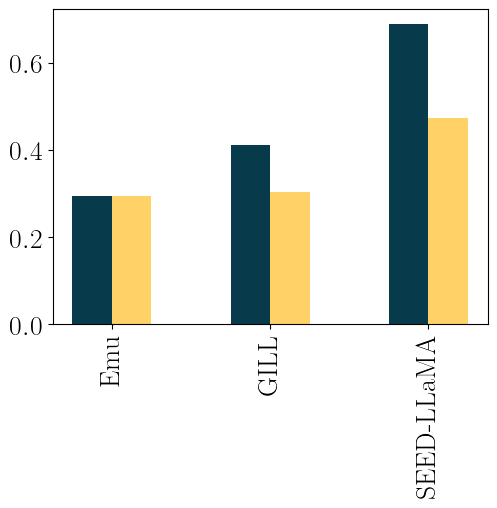

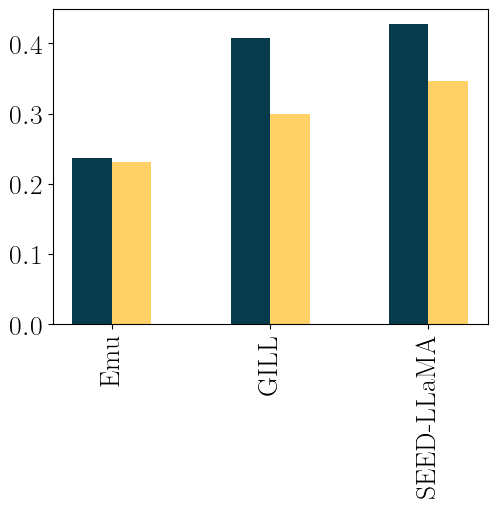

In [26]:
model_mode = 'text'
misleading = 0
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10

for model_mode in ['image']:
    for misleading in [0,1]:
        results = {}
        for metric in ['obj', 'detail']:
            results[metric] = {}
            for model in model_dict[model_mode]:
                results[metric][model] = {}
                for shot in num_shots:
                    results[metric][model][shot] = []
                    for task_id in task_dataframe:
                        results[metric][model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            misleading = misleading,
                        ))
                    results[metric][model][shot] = np.mean(results[metric][model][shot])

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.98, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticklabels = []
        for i, model in enumerate(model_dict[model_mode]):
            ax.bar(barspace*i, results['obj'][model][num_shot], width = bar_width, color = colors[0], label = 'Object-Generation Accuracy')
            ax.bar(barspace*i + bar_width, results['detail'][model][num_shot], width = bar_width, color = colors[1], label = 'Attribute-Generation Accuracy')
            xticklabels.append(model_dict[model_mode][model])
            
            # if i == 0: ax.legend(bbox_to_anchor=(.5, .75), ncol=1, fontsize=15)
            
        ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
        ax.set_xticklabels(xticklabels, rotation = 90)
        fig.savefig(f'{root_dir}/figures/impact_obj_detail_shot_{num_shot}_{model_mode}_{misleading}.pdf')
        plt.show()

# Textual v.s. Visual

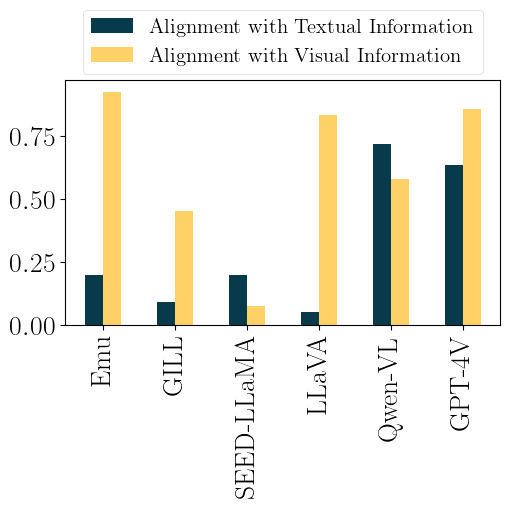

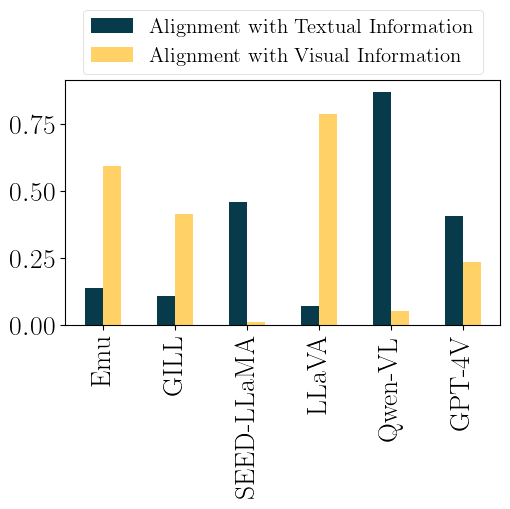

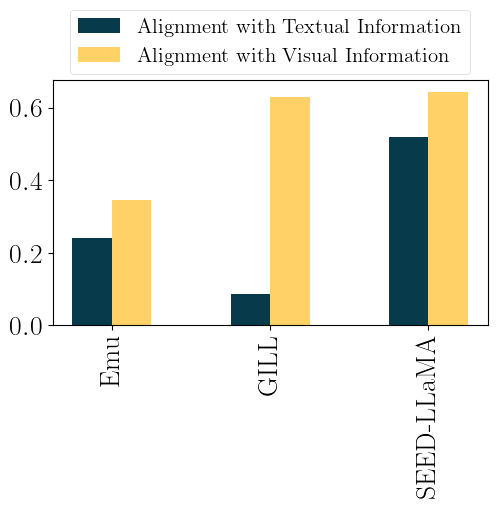

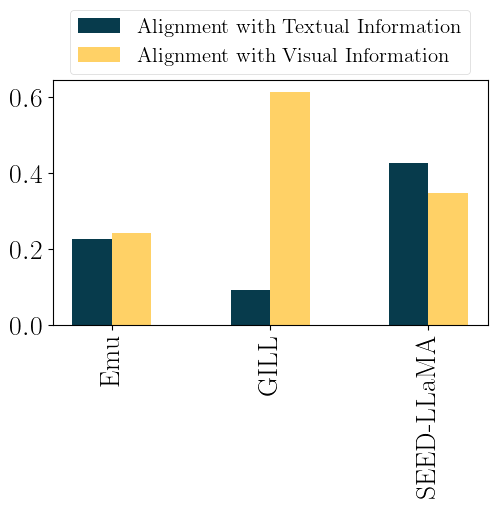

In [18]:
model_mode = 'text'
misleading = 0
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10

for model_mode in ['text', 'image']:
    for misleading in [0,1]:
        results = {}
        for metric in ['textual', 'visual']:
            results[metric] = {}
            for model in model_dict[model_mode]:
                results[metric][model] = {}
                for shot in num_shots:
                    results[metric][model][shot] = []
                    for task_id in task_dataframe:
                        results[metric][model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            misleading = misleading,
                        ))
                    results[metric][model][shot] = np.mean(results[metric][model][shot])

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.84, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticklabels = []
        for i, model in enumerate(model_dict[model_mode]):
            ax.bar(barspace*i, results['textual'][model][num_shot], width = bar_width, color = colors[0], label = 'Alignment with Textual Information')
            ax.bar(barspace*i + bar_width, results['visual'][model][num_shot], width = bar_width, color = colors[1], label = 'Alignment with Visual Information')
            xticklabels.append(model_dict[model_mode][model])
            
            if i == 0: ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.33), ncol=1, fontsize=15)
            
        ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
        ax.set_xticklabels(xticklabels, rotation = 90)
        fig.savefig(f'{root_dir}/figures/impact_textual_visual_shot_{num_shot}_{model_mode}_{misleading}.pdf')
        plt.show()